In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import matplotlib.patches as patches
import matplotlib
import tifffile
import os
import numpy as np
import sys
import dxchange
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage as ndimage
%matplotlib inline

astropy module not found
olefile module not found


In [2]:
import numpy as np
import tifffile
from holotomocupy.utils import *

iter = 64
bin = 0
ss = 1024//2**bin
nx, ny, nz = 3216//2**bin, 3216//2**bin, 2048//2**bin


In [ ]:
mrec0 = tifffile.imread(f'/data2/vnikitin/brain_rec/20251115/Y350a1234/2250_2048_{bin}_0.0_0.003_0.05_1e-06_20_1.1_0/rec_obj_real/{iter:04}.tiff')
mrec0 = mrec0[mrec0.shape[0]//2-ss:mrec0.shape[0]//2+ss,
            mrec0.shape[1]//2-ss:mrec0.shape[1]//2+ss,
            mrec0.shape[2]//2-ss:mrec0.shape[2]//2+ss]

mrec1 = tifffile.imread(f'/data2/vnikitin/brain_rec/20251115/Y350a1234/2250_2048_{bin}_0.0_0.003_0.05_1e-06_20_1.1_1/rec_obj_real/{iter:04}.tiff')
mrec1 = mrec1[mrec1.shape[0]//2-ss:mrec1.shape[0]//2+ss,
            mrec1.shape[1]//2-ss:mrec1.shape[1]//2+ss,
            mrec1.shape[2]//2-ss:mrec1.shape[2]//2+ss]


In [ ]:
def halfbit(data, center):
    z, y, x = np.indices((data.shape))
    r = np.sqrt((x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2)
    r=r.astype(np.int32)
    nr = np.bincount(r.ravel())
    return (0.2071+1.9102/np.sqrt(nr))/(1.2071+0.9102/np.sqrt(nr)) 

def radial_profile(data, center):
    z, y, x = np.indices((data.shape))
    r = np.sqrt((x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2)
    r=r.astype(np.int32)
    

    tbinre = np.bincount(r.ravel(), data.real.ravel())
    tbinim = np.bincount(r.ravel(), data.imag.ravel())
    
    nr = np.bincount(r.ravel())
    radialprofile = (tbinre+1j*tbinim) / np.sqrt(nr)
    
    return radialprofile
from scipy.signal import savgol_filter

def smooth_savgol(data, window_size, poly_order):
    if window_size % 2 == 0 or window_size < 1:
      raise ValueError("Window size must be an odd positive integer")
    if poly_order >= window_size:
       raise ValueError("poly_order must be less than window_size")
    data = np.pad(data,(32,32),'edge')
    data = savgol_filter(data, window_size, poly_order)
    data=data[32:-32]
    return data

In [ ]:

wsize = ss

ff1 = np.zeros([2*wsize,2*wsize,2*wsize],dtype='complex64')
hbit = halfbit(ff1,np.array([2*wsize,2*wsize,2*wsize])//2)
np.save('hbit.npy',hbit)
len(hbit)


1774

In [ ]:
mmrec0 = mrec0[mrec0.shape[0]//2-wsize:mrec0.shape[0]//2+wsize,mrec0.shape[1]//2-wsize:mrec0.shape[1]//2+wsize,mrec0.shape[2]//2-wsize:mrec0.shape[2]//2+wsize]
mmrec1 = mrec1[mrec1.shape[0]//2-wsize:mrec1.shape[0]//2+wsize,mrec1.shape[1]//2-wsize:mrec1.shape[1]//2+wsize,mrec1.shape[2]//2-wsize:mrec1.shape[2]//2+wsize]
mmrec0 = np.fft.fftshift(np.fft.fftn(mmrec0))
mmrec1 = np.fft.fftshift(np.fft.fftn(mmrec1))

frc2 = radial_profile(mmrec0*np.conj(mmrec1),np.array(mmrec0.shape)//2)/\
    np.sqrt(radial_profile(np.abs(mmrec0)**2,np.array(mmrec0.shape)//2)*radial_profile(np.abs(mmrec1)**2,np.array(mmrec0.shape)//2))

# a = np.hamming(2*len(frc2))
# a = a[len(a)//2:]
# frc2*=a
# frc2=np.abs(frc2)[:wsize]
np.save(f'frc2{iter}.npy',frc2)



In [ ]:
mmrec0.shape

(2048, 2048, 2048)

In [ ]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],  # fallbacks
})

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",   # Times-like math
    # optional:
    # "mathtext.default": "regular",
})
mpl.rcParams['font.size'] = 24  # optional
mpl.rcParams["xtick.labelsize"] = 22
mpl.rcParams["ytick.labelsize"] = 22

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1060281/2445902786.py:19: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel(f'Spatial frequency (1/$\mu$m)')
/home/beams/TOMO/conda/miniforge3/envs/holotomocupy/lib/python3.12/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)


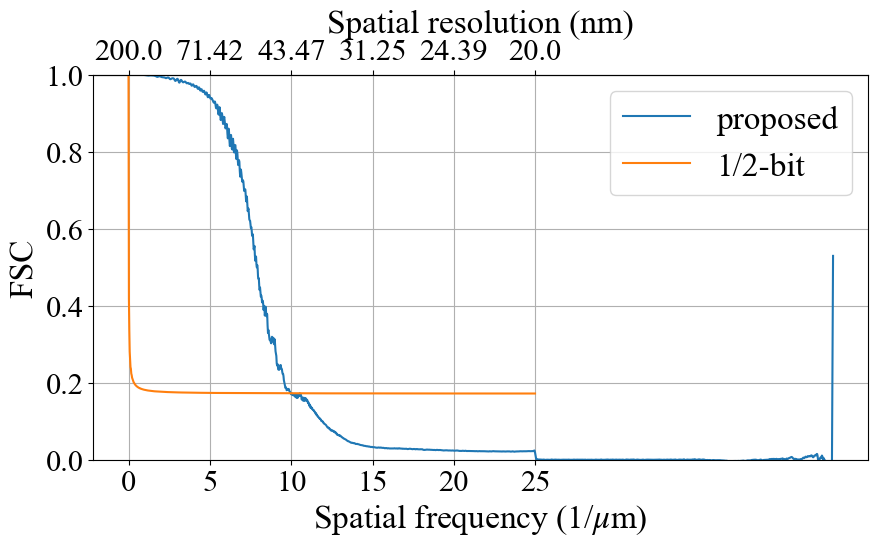

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(10,5))


frc2=np.load('frc2.npy')
frc2c=smooth_savgol(frc2, 11, 5)
hbit=np.load('hbit.npy')

ax.plot(frc2c[:].real,linewidth=1.5, label=f'proposed')

ax.plot(hbit[:wsize],linewidth=1.5,label='1/2-bit')

ax.grid()
ax.set_ylim([0,1])
lg = plt.legend(loc="upper right")
lg.get_title().set_fontsize(16)
plt.ylabel('FSC',rotation=90)
ax2 = ax.secondary_xaxis('top')
ax.set_xlabel(f'Spatial frequency (1/$\mu$m)')
ax2.set_xlabel('Spatial resolution (nm)')
ax.set_xticks(np.linspace(0,wsize,6),np.int32(np.linspace(0,1/(2*20e-9),6)/1e6))
ax2.set_xticks(np.linspace(0,wsize,6),(np.int32(20000*2**bin/np.linspace(1,10,6))/100))
# # plt.show()
# plt.savefig(f'{iter}_{wsize}.png',dpi=300)

In [ ]:
128e-6/40e-9

3200.0